# 6-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기


## # 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## # 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Installing automake (A dependency for mecab-ko)
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease   
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates/multiverse amd64 Packages [34.5 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/restricted amd64 Packages [771 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2,954 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2,242 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,463 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [26.8 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,516 kB]
Get:12 http://security.ubuntu.com/ubuntu b

In [3]:
!python3 -m pip install konlpy       # Python 3.x

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [4]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


> 사실 해당 함수를 나름 구현해보겠다고 해봤으나 `사전word_to_index구성`부터 막혀서 일단 아이펠의 코드를 복붙했다.

In [6]:
# decode용 딕셔너리
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## # 모델 구성을 위한 데이터 분석 및 가공
> 문장의 평균 길이와 표준편차, 그리고 이 둘을 이용해 95%의 문장을 커버하는 max_len을 구해야 한다

In [8]:
sentence_lengths = np.array([len(indexed_sentence) for indexed_sentence in X_train])
mean = sentence_lengths.mean()
std = sentence_lengths.std()
max_len = int(mean + 2 * std)

print(f'    평균 : {mean}')
print(f' 표준편차 : {std}')
print(f'max_len : {max_len}')
print(f'커버 범위 : {len(sentence_lengths[sentence_lengths < max_len]) / len(sentence_lengths):2%}')

    평균 : 15.981687211831826
 표준편차 : 12.824686694216712
max_len : 41
커버 범위 : 93.049076%


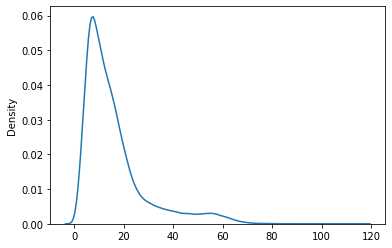

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(sentence_lengths)
plt.show()

In [10]:
X_train[:4]

[[32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
 [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391],
 [24, 205, 3],
 [8410, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]]

#### 패딩 추가하기

> 패딩을 추가하려다 보니 `<BOS>`, `<PAD>`, `<UNK>` 가 word_to_index에 없어서 오류가 났다.  
> word_to_index 맨 앞쪽에 추가하기

In [11]:
print('<BOS>' in word_to_index)
print('<PAD>' in word_to_index)
print('<UNK>' in word_to_index)
print('.' in word_to_index)

False
False
False
True


In [12]:
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2

In [13]:
print('<BOS>' in word_to_index)
print('<PAD>' in word_to_index)
print('<UNK>' in word_to_index)
print('.' in word_to_index)

True
True
True
True


In [14]:
import tensorflow as tf

# 'pre'로 데이터에 패딩 추가
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=max_len)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=max_len)

print(X_train_pre.shape)

(146182, 41)


## # 모델 구성 및 validation set 구성

#### 모델은 아래의 것들로 구성해 볼 예정이다.
- LSTM 이용
- 1-D CNN 이용
- Global Max Pooling 이용
- 그리고 가능하다면 인터넷에서 찾아본 다른 모델 이용(원리는 아직 전혀 모른다...)

In [15]:
# 먼저 `vocab_size` 다시 한 번 확인
len(word_to_index)

10000

> Embedding Layer의 `output_dim` 파라미터...  
> '왜 4를 넣는거지?' 하고 Word2Vec에 관한 블로그를 읽어도 이해가 되지 않던 중 결국 같은 LMS 조원들의 도움 덕분에 저것이 임의로 지정하는 하이퍼파라미터라는 것을 알게 되었다.  
> 그래서 나는 여기서 인터넷 검색하면서 발견한 '32'라는 숫자를 넣어보겠다.

In [16]:
# RNN 모델
vocab_size = 10000
word_vector_dim = 32 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(64))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 346,945
Trainable params: 346,945
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 1-D CNN으로 만든 모델 구현

model_1dcon = tf.keras.Sequential()
model_1dcon.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcon.add(tf.keras.layers.Conv1D(32, 7, activation='relu')) # word_vector_dim과 맞춰봤습니다.
model_1dcon.add(tf.keras.layers.MaxPooling1D(5))
model_1dcon.add(tf.keras.layers.Conv1D(32, 7, activation='relu')) # word_vector_dim과 맞춰봤습니다.
model_1dcon.add(tf.keras.layers.GlobalMaxPooling1D())
model_1dcon.add(tf.keras.layers.Dense(16, activation='relu'))
model_1dcon.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1dcon.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          7200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:
# GlobalMaxPolling만 있는 것 

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(16, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 320,545
Trainable params: 320,545
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Dense Layer만으로 파라미터 많이 생성되게 한 모델
# 파라미터가 많아지면 좋아지나 싶어서 100만 넘도록 해봄

model_dense = tf.keras.Sequential()
model_dense.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_dense.add(tf.keras.layers.Dense(1024, activation='relu'))
model_dense.add(tf.keras.layers.Dense(512, activation='relu'))
model_dense.add(tf.keras.layers.Dense(256, activation='relu'))
model_dense.add(tf.keras.layers.Dense(256, activation='relu'))
model_dense.add(tf.keras.layers.Dense(256, activation='relu'))
model_dense.add(tf.keras.layers.Dense(256, activation='relu'))
model_dense.add(tf.keras.layers.Dense(128, activation='relu'))
model_dense.add(tf.keras.layers.Dense(64, activation='relu'))
model_dense.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_dense.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
dense_6 (Dense)              (None, None, 1024)        33792     
_________________________________________________________________
dense_7 (Dense)              (None, None, 512)         524800    
_________________________________________________________________
dense_8 (Dense)              (None, None, 256)         131328    
_________________________________________________________________
dense_9 (Dense)              (None, None, 256)         65792     
_________________________________________________________________
dense_10 (Dense)             (None, None, 256)         65792     
_________________________________________________________________
dense_11 (Dense)             (None, None, 256)        

### Validation set 구분

In [20]:
# train_test_split으로 나눠보겠습니다.
from sklearn.model_selection import train_test_split

xx_train, xx_validation, yy_train, yy_validation = train_test_split(X_train_pre,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                   random_state=2022)

### 모델 각각 훈련

In [21]:
EPOCHS = 10

#### # LSTM

In [22]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_lstm.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 7s - loss: 0.4390 - accuracy: 0.7947 - val_loss: 0.3615 - val_accuracy: 0.8411
Epoch 2/10
229/229 - 3s - loss: 0.3335 - accuracy: 0.8571 - val_loss: 0.3567 - val_accuracy: 0.8461
Epoch 3/10
229/229 - 3s - loss: 0.3117 - accuracy: 0.8683 - val_loss: 0.3450 - val_accuracy: 0.8491
Epoch 4/10
229/229 - 3s - loss: 0.2958 - accuracy: 0.8742 - val_loss: 0.3497 - val_accuracy: 0.8481
Epoch 5/10
229/229 - 3s - loss: 0.2800 - accuracy: 0.8803 - val_loss: 0.3525 - val_accuracy: 0.8520
Epoch 6/10
229/229 - 3s - loss: 0.2630 - accuracy: 0.8873 - val_loss: 0.3567 - val_accuracy: 0.8496
Epoch 7/10
229/229 - 3s - loss: 0.2445 - accuracy: 0.8955 - val_loss: 0.3873 - val_accuracy: 0.8505
Epoch 8/10
229/229 - 3s - loss: 0.2268 - accuracy: 0.9039 - val_loss: 0.3935 - val_accuracy: 0.8501
Epoch 9/10
229/229 - 3s - loss: 0.2136 - accuracy: 0.9098 - val_loss: 0.4052 - val_accuracy: 0.8499
Epoch 10/10
229/229 - 3s - loss: 0.1964 - accuracy: 0.9175 - val_loss: 0.4283 - val_accuracy: 0.8418

In [23]:
# test 셋으로 평가해보기
results = model_lstm.evaluate(X_test_pre, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4241 - accuracy: 0.8403
[0.42413806915283203, 0.8403482437133789]


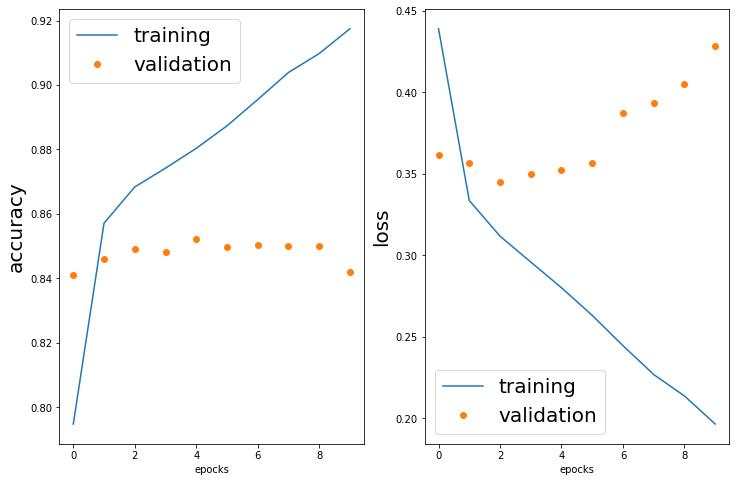

In [24]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()

> LSTM의 경우(에포크 10)
>  - train = 약 92%, val = 약 84%, test = 약 84%가 나왔다.
>  - 특히 에포크마다 같이 테스트된 validation 셋의 지표는 더 좋아지지 않았고 에포크 5부터는 overfitting이 일어나기 시작했다.  
>  - 해당 레이어로 설계된 모델 혹은 임베딩된 워드벡터 품질이 안 좋은 것 같다.

#### # 1-D Con

In [25]:
model_1dcon.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_1dcon.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 9s - loss: 0.4564 - accuracy: 0.7795 - val_loss: 0.3497 - val_accuracy: 0.8481
Epoch 2/10
229/229 - 2s - loss: 0.3153 - accuracy: 0.8665 - val_loss: 0.3436 - val_accuracy: 0.8490
Epoch 3/10
229/229 - 2s - loss: 0.2736 - accuracy: 0.8873 - val_loss: 0.3375 - val_accuracy: 0.8542
Epoch 4/10
229/229 - 2s - loss: 0.2290 - accuracy: 0.9100 - val_loss: 0.3576 - val_accuracy: 0.8525
Epoch 5/10
229/229 - 2s - loss: 0.1791 - accuracy: 0.9334 - val_loss: 0.3945 - val_accuracy: 0.8471
Epoch 6/10
229/229 - 2s - loss: 0.1308 - accuracy: 0.9549 - val_loss: 0.4503 - val_accuracy: 0.8419
Epoch 7/10
229/229 - 2s - loss: 0.0938 - accuracy: 0.9699 - val_loss: 0.5108 - val_accuracy: 0.8384
Epoch 8/10
229/229 - 2s - loss: 0.0680 - accuracy: 0.9792 - val_loss: 0.5794 - val_accuracy: 0.8366
Epoch 9/10
229/229 - 2s - loss: 0.0503 - accuracy: 0.9855 - val_loss: 0.6538 - val_accuracy: 0.8322
Epoch 10/10
229/229 - 2s - loss: 0.0395 - accuracy: 0.9883 - val_loss: 0.7521 - val_accuracy: 0.8276

In [26]:
# test 셋으로 평가해보기
results = model_1dcon.evaluate(X_test_pre, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.7618 - accuracy: 0.8293
[0.761829137802124, 0.8292816877365112]


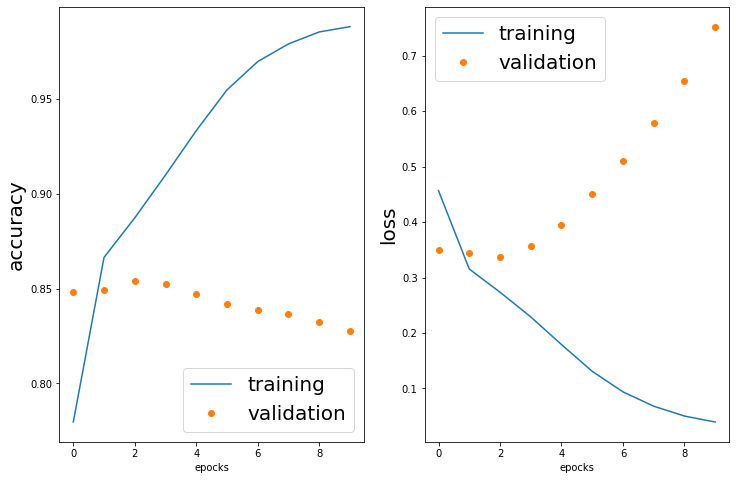

In [27]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()

> 1-D CNN의 경우(에포크 10)
>  - train = 약 99%, val = 약 83%, test = 약 82%가 나왔다.
>  - 위의 LSTM과 마찬가지로 트레인셋에만 훌륭하게 학습되었다.  
>  - 다만 LSTM 모델보다는 빠르게(?) overfitting 되었다.
>  - 해당 레이어로 설계된 모델 혹은 임베딩된 워드벡터 품질이 안 좋은 것 같다.

#### # Global Max Pooling

In [28]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_gmp.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 2s - loss: 0.5240 - accuracy: 0.7877 - val_loss: 0.3804 - val_accuracy: 0.8316
Epoch 2/10
229/229 - 1s - loss: 0.3388 - accuracy: 0.8540 - val_loss: 0.3519 - val_accuracy: 0.8447
Epoch 3/10
229/229 - 1s - loss: 0.2956 - accuracy: 0.8762 - val_loss: 0.3496 - val_accuracy: 0.8468
Epoch 4/10
229/229 - 1s - loss: 0.2658 - accuracy: 0.8917 - val_loss: 0.3561 - val_accuracy: 0.8479
Epoch 5/10
229/229 - 1s - loss: 0.2406 - accuracy: 0.9048 - val_loss: 0.3660 - val_accuracy: 0.8450
Epoch 6/10
229/229 - 1s - loss: 0.2180 - accuracy: 0.9154 - val_loss: 0.3833 - val_accuracy: 0.8443
Epoch 7/10
229/229 - 1s - loss: 0.1976 - accuracy: 0.9252 - val_loss: 0.4026 - val_accuracy: 0.8406
Epoch 8/10
229/229 - 1s - loss: 0.1786 - accuracy: 0.9342 - val_loss: 0.4248 - val_accuracy: 0.8384
Epoch 9/10
229/229 - 1s - loss: 0.1614 - accuracy: 0.9419 - val_loss: 0.4483 - val_accuracy: 0.8362
Epoch 10/10
229/229 - 1s - loss: 0.1457 - accuracy: 0.9485 - val_loss: 0.4742 - val_accuracy: 0.8337

In [29]:
# test 셋으로 평가해보기
results = model_gmp.evaluate(X_test_pre, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4766 - accuracy: 0.8339
[0.47662121057510376, 0.833858847618103]


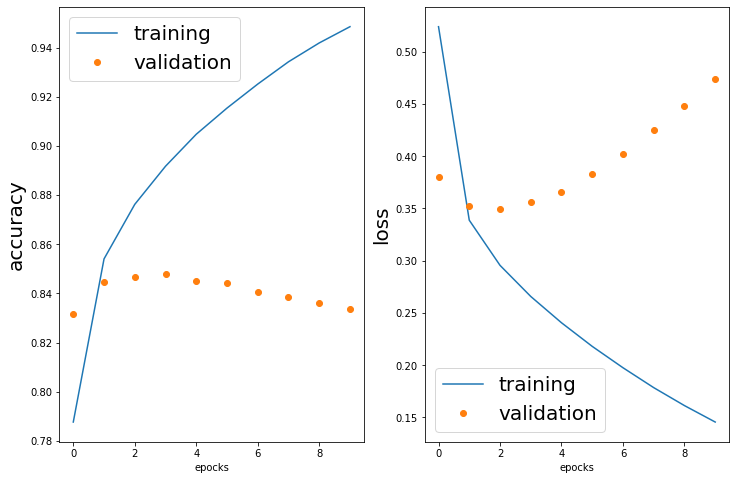

In [30]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()

> GMP의 경우(에포크 10)
>  - train = 약 94%, val = 약 83%, test = 약 83%가 나왔다.
>  - 위의 두 모델과 마찬가지로 트레인셋에만 훌륭하게 학습되었다.  
>  - 해당 레이어로 설계된 모델 혹은 임베딩된 워드벡터 품질이 안 좋은 것 같다.

#### # Dense layer로만 100만 파라미터 넘게

In [31]:
model_dense.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_dense.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 24s - loss: 0.6842 - accuracy: 0.5238 - val_loss: 0.6760 - val_accuracy: 0.5388
Epoch 2/10
229/229 - 22s - loss: 0.6738 - accuracy: 0.5424 - val_loss: 0.6759 - val_accuracy: 0.5430
Epoch 3/10
229/229 - 22s - loss: 0.6729 - accuracy: 0.5440 - val_loss: 0.6747 - val_accuracy: 0.5428
Epoch 4/10
229/229 - 22s - loss: 0.6726 - accuracy: 0.5448 - val_loss: 0.6747 - val_accuracy: 0.5428
Epoch 5/10
229/229 - 22s - loss: 0.6725 - accuracy: 0.5451 - val_loss: 0.6746 - val_accuracy: 0.5433
Epoch 6/10
229/229 - 22s - loss: 0.6724 - accuracy: 0.5456 - val_loss: 0.6759 - val_accuracy: 0.5434
Epoch 7/10
229/229 - 22s - loss: 0.6724 - accuracy: 0.5462 - val_loss: 0.6749 - val_accuracy: 0.5432
Epoch 8/10
229/229 - 22s - loss: 0.6724 - accuracy: 0.5455 - val_loss: 0.6750 - val_accuracy: 0.5418
Epoch 9/10
229/229 - 22s - loss: 0.6722 - accuracy: 0.5459 - val_loss: 0.6745 - val_accuracy: 0.5430
Epoch 10/10
229/229 - 22s - loss: 0.6722 - accuracy: 0.5453 - val_loss: 0.6745 - val_accura

In [32]:
# test 셋으로 평가해보기
results = model_dense.evaluate(X_test_pre, y_test, verbose=2)

print(results)

1537/1537 - 9s - loss: 0.6743 - accuracy: 0.5459
[0.6742663383483887, 0.5459061861038208]


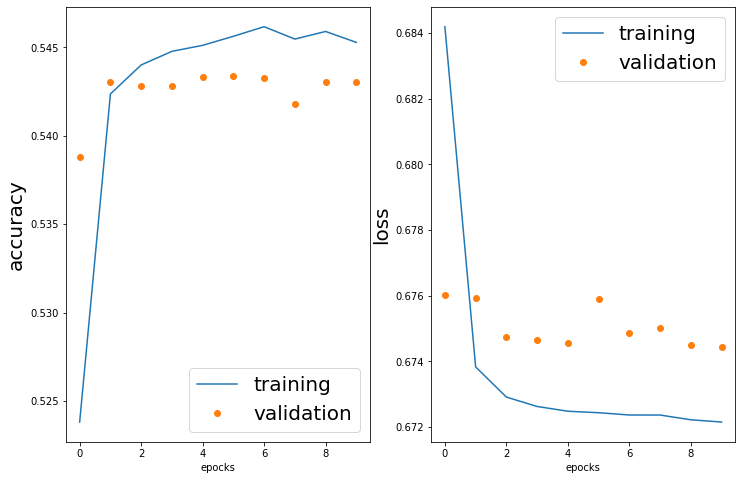

In [33]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()

> dense layer만 있는 경우(에포크 10)
>  - train = 약 54%, val = 약 54%, test = 약 54%가 나왔다.
>  - 둘 중 하나 찍어도 50%인데 이건 모델 자체도 별로인 듯하다....
>  - Dense layer만 있으면 대략 아무 것도 못한다는 배움(?)을 얻은 것 같다.

## # 학습된 임베딩 레이어 분석

In [34]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [35]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/practice_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

> pre-trained 모델을 가져올 때 생기는 에러로 gensim을 사용하는 순간부터 downgraded 된 버전으로 설치함

In [36]:
!pip install gensim==3.8.3

import gensim

gensim.__version__

     |████████████████████████████████| 24.2 MB 21.9 MB/s eta 0:00:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


'3.8.3'

In [37]:
word_vectors = gensim.models.keyedvectors.Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.04241488, -0.00012171, -0.03687009,  0.02396451,  0.05803311,
        0.03160533, -0.03439193,  0.06026774,  0.0729382 ,  0.08736394,
        0.0439916 ,  0.03483137, -0.0745207 ,  0.03991708, -0.05535474,
       -0.01540734,  0.05892337,  0.04202316, -0.02229529,  0.0108406 ,
        0.01592908,  0.04492246, -0.03567177, -0.0053763 ,  0.02020527,
        0.02136189,  0.02337406,  0.00956615, -0.04516129,  0.00602037,
        0.01837775,  0.0428514 ], dtype=float32)

In [38]:
word_vectors.similar_by_word('영화')

[('박자', 0.6198108792304993),
 ('스타일', 0.5904603004455566),
 ('갖', 0.5793795585632324),
 ('방법', 0.5746837854385376),
 ('"""', 0.5726088285446167),
 ('네요', 0.5686880946159363),
 ('수잔', 0.5651038885116577),
 ('짐캐리', 0.5484471321105957),
 ('입니다', 0.5463017225265503),
 ('냥', 0.5370578765869141)]

> 딱 봐도 연관성이 없다....  
> 혹시 다른 모델에 쓰인 임베딩 레이어는 다를까?

In [39]:
embedding_layer = model_1dcon.layers[0] # 모델 변경
weights = embedding_layer.get_weights()[0]
print(weights.shape)    

(10000, 32)


In [40]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/practice2_word2vec.txt' # 다른 경로
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = embedding_layer.get_weights()[0] 
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = gensim.models.keyedvectors.Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word('영화')

[('으다', 0.6505240797996521),
 ('백', 0.6457682251930237),
 ('b', 0.6294980049133301),
 ('취미', 0.5602571368217468),
 ('스타워즈', 0.556815505027771),
 ('크기', 0.5542166829109192),
 ('굵', 0.5493003129959106),
 ('지극히', 0.5475529432296753),
 ('터지', 0.5426718592643738),
 ('미아', 0.5202059149742126)]

> 오 왠지는 모르겠지만, 임베딩이 다르게 된다...

## # pre-trained 임베딩 레이어 가져오기

In [41]:
# pre-trained word2vec 가져오기
import os
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [42]:
# 객체 확인
word2vec

In [43]:
word2vec['영화'].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

In [44]:
word2vec.similar_by_word('영화')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

In [45]:
# 워드벡터에 있는 단어들의 vector 값을 복사
vocab_size = 10000  # 어휘 사전 크기
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [46]:
embedding_matrix.shape

(10000, 200)

### # 모델에 임베딩 레이어 넣어서 훈련 및 예측

In [47]:
# 위의 RNN 모델과 word_vector_dim 제외하고 동일하게 세팅
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200 

model_lstm_new = tf.keras.Sequential()
model_lstm_new.add(tf.keras.layers.Embedding(vocab_size,
                                             word_vector_dim,
                                             embeddings_initializer=Constant(embedding_matrix),
                                             trainable=True,
                                             input_length=max_len,
                                             input_shape=(None,)))
model_lstm_new.add(tf.keras.layers.LSTM(64))
model_lstm_new.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm_new.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm_new.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 2,069,953
Trainable params: 2,069,953
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_lstm_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_lstm_new.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 10s - loss: 0.4726 - accuracy: 0.7668 - val_loss: 0.3804 - val_accuracy: 0.8301
Epoch 2/10
229/229 - 7s - loss: 0.3351 - accuracy: 0.8554 - val_loss: 0.3366 - val_accuracy: 0.8530
Epoch 3/10
229/229 - 7s - loss: 0.2919 - accuracy: 0.8771 - val_loss: 0.3262 - val_accuracy: 0.8591
Epoch 4/10
229/229 - 7s - loss: 0.2656 - accuracy: 0.8899 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 5/10
229/229 - 7s - loss: 0.2388 - accuracy: 0.9030 - val_loss: 0.3336 - val_accuracy: 0.8578
Epoch 6/10
229/229 - 7s - loss: 0.2183 - accuracy: 0.9132 - val_loss: 0.3620 - val_accuracy: 0.8494
Epoch 7/10
229/229 - 7s - loss: 0.1988 - accuracy: 0.9225 - val_loss: 0.3571 - val_accuracy: 0.8592
Epoch 8/10
229/229 - 7s - loss: 0.1757 - accuracy: 0.9321 - val_loss: 0.3970 - val_accuracy: 0.8516
Epoch 9/10
229/229 - 7s - loss: 0.1565 - accuracy: 0.9413 - val_loss: 0.4008 - val_accuracy: 0.8564
Epoch 10/10
229/229 - 7s - loss: 0.1358 - accuracy: 0.9496 - val_loss: 0.4496 - val_accuracy: 0.852

In [49]:
# test 셋으로 평가해보기
results = model_lstm_new.evaluate(X_test_pre, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4557 - accuracy: 0.8496
[0.4556523263454437, 0.8495839834213257]


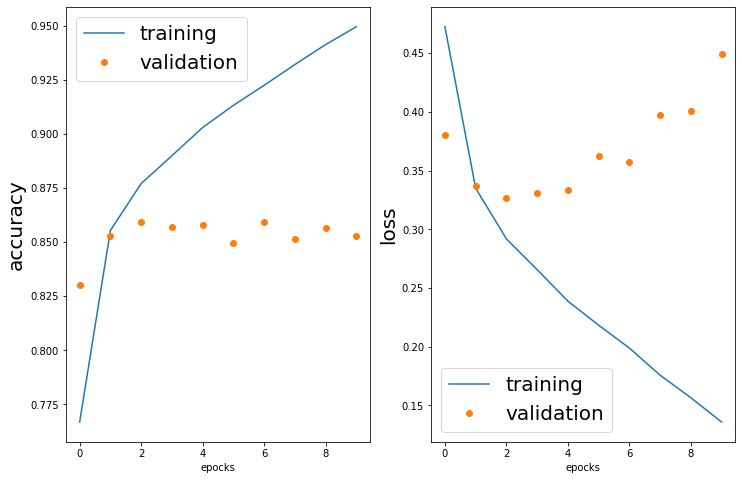

In [50]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()

> LSTM with new word2vec의 경우 위의 LSTM과 비교했을 때,(에포크 10)
>  - train = 약 92% -> 95%, val = 약 84% -> 85%, test = 약 84% -> 85%로 정말 근소하게 개선됐다.
>  - 사실 개선됐는지도 모르겠다.
>  - validatoin 셋에서 보인 미비한 정확도 개선과 overfitting 스러움은 동일하게 남았다.
>  - 어쩜 LSTM 한 층과 Dense layer로 구성된 모델은 좋은 품질의 word2vec이어도 어쩔 수 없는 모델상 한계가 있나보다.
>  - 아이펠 코드에 있던 모델로 한 번 테스트해봐야겠다.

### # 모델 재설계 후 새로운 word2vec 효과 확인해보기

In [51]:
# 위에서 LSTM과 Dense 사이에 Conv1D -> MaxPooling -> Con1D -> Conv1D -> MaxPooling 추가
model_final = tf.keras.Sequential()
model_final.add(tf.keras.layers.Embedding(vocab_size,
                                             word_vector_dim,
                                             embeddings_initializer=Constant(embedding_matrix),
                                             trainable=True,
                                             input_length=max_len,
                                             input_shape=(None,)))
model_final.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_final.add(tf.keras.layers.MaxPooling1D(5))
model_final.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_final.add(tf.keras.layers.GlobalMaxPooling1D())
model_final.add(tf.keras.layers.Dense(8, activation='relu'))
model_final.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_final.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

In [52]:
model_final.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_final.fit(xx_train,
                         yy_train,
                         epochs=EPOCHS,
                         batch_size=512,
                        validation_data=(xx_validation, yy_validation),
                        verbose=2)

Epoch 1/10
229/229 - 13s - loss: 0.5851 - accuracy: 0.6766 - val_loss: 0.4543 - val_accuracy: 0.7876
Epoch 2/10
229/229 - 6s - loss: 0.4016 - accuracy: 0.8193 - val_loss: 0.3956 - val_accuracy: 0.8231
Epoch 3/10
229/229 - 6s - loss: 0.3345 - accuracy: 0.8560 - val_loss: 0.3620 - val_accuracy: 0.8411
Epoch 4/10
229/229 - 6s - loss: 0.2978 - accuracy: 0.8751 - val_loss: 0.3633 - val_accuracy: 0.8436
Epoch 5/10
229/229 - 6s - loss: 0.2700 - accuracy: 0.8891 - val_loss: 0.3606 - val_accuracy: 0.8464
Epoch 6/10
229/229 - 6s - loss: 0.2461 - accuracy: 0.9012 - val_loss: 0.3696 - val_accuracy: 0.8463
Epoch 7/10
229/229 - 6s - loss: 0.2245 - accuracy: 0.9118 - val_loss: 0.3907 - val_accuracy: 0.8396
Epoch 8/10
229/229 - 6s - loss: 0.2038 - accuracy: 0.9217 - val_loss: 0.4117 - val_accuracy: 0.8384
Epoch 9/10
229/229 - 6s - loss: 0.1828 - accuracy: 0.9308 - val_loss: 0.4272 - val_accuracy: 0.8366
Epoch 10/10
229/229 - 6s - loss: 0.1602 - accuracy: 0.9418 - val_loss: 0.4526 - val_accuracy: 0.839

In [53]:
# test 셋으로 평가해보기
results = model_final.evaluate(X_test_pre, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4621 - accuracy: 0.8356
[0.46211913228034973, 0.8356286883354187]


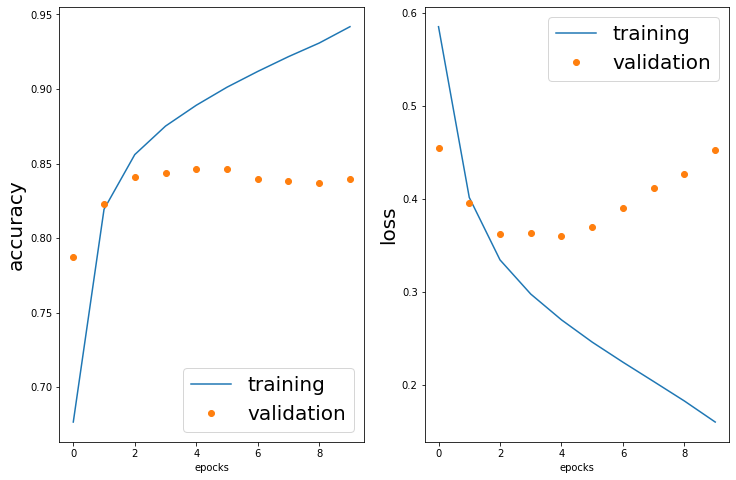

In [54]:
# 그래프로 그려보기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='training')
plt.plot(val_acc, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(loss, label='training')
plt.plot(val_loss, 'o', label='validation')
plt.xlabel('epocks')
plt.ylabel('loss', fontsize=20)
plt.legend(fontsize=20)

plt.show()

> 새로운 Word2Vec과 LMS에 있던 모델 사용
>  - train = 약 93%, validation = 약 83%, test = 약 83%
>  - 결과적으로 새로운 word2vec으로도 내 지식 범위 안에 있는 수준에서는 test 데이터에서 90% 이상의 정확도를 내지는 못했다.

## # 회고
#### Point 1) 패키지 사용의 어려움
- 이번 exploration에서 권고한 Mecab과 gensim은 여러모로 사용하기 불편했다.
- Mecab은 설치가 안되어 있는듯 이 주피터노트북을 실행할 때마다 설치하라고 계속 오류를 냈고,
- gensim은 LMS에서 알려주듯 처음붙 3.x.x대로 downgrade하고 시작을 했으나, 그래도 pre-trained 모델을 불러오는 데 오류를 냈었다.(이래저래 해결 방법을 찾다가 퍼실 분들의 예전 교육생 시절 주피터에 쓰인 코드를 보고 현재 LMS상 쓰여 있는 method명과 다르단 점을 발견했다. 그리고 변경하니 해결됐다)
- 실무에 들어가면 이런 식으로 부딪히는 면이 많을 텐데, 이와 관련된 가상환경 구축(?)도 적응해야 할 듯 하다.

#### Point 2) Word2Vec의 성능 확인
- pre-trained 된 word2vec을 가져오면 학습과 예측에 굉장히 큰 개선이 있을 줄 알았다.
- 어쩜 나의 코드상 문제일 수도 있는데, 여튼 별다른 정확도 개선이 이루어지지 않았다.
- 가설로는 1) word2vec도 어쩔 수 없이 모델의 설계에 많이 영향을 받는다.
- 2) 내 코드가 잘못되었다.
- 근데 뭐가 됐든 word2vec의 상태를 뜯어보기엔 뭔가 많이 추상적이라는 생각이 들었다.

#### Point 3) 한국말 pre-trained 모델의 부족
- 위와 같은 어려움 때문에 사실 다른 모델을 찾아보려 했다.
- 그러다 SKT에서 만든 KoBERT라는 걸 봤는데, 그건 학습이 너무 오래 걸렸고, 나중 가서는 메모리 부족으로 오류가 났다...

#### 요약하면...
일단 NLP라는 것을 조금씩 경험해보고 있다는 것에 의미를 두고, 그것이 어떤 단계들을 거쳐서(토큰화 -> 단어사전 구축 -> 패딩 -> word2vec 만들기(임베딩) -> 학습 및 예측) 진행되는지를 머릿속에 한 번 더 그려보면서 마무리해야겠다.